##  scCODA - Compositional analysis of labeled single-cell data

In [13]:
import warnings
warnings.filterwarnings("ignore")

import mudata as mu
import matplotlib.pyplot as plt
import scanpy as sc
import pertpy as pt
import pandas as pd
import os
plt.rcParams['figure.figsize'] = (12, 10)

In [4]:
# path of partly preprocessed HLCA file used in this notebook:
adata_path = "/home/h/hollenberg/MaPra/adata_radiation_processed.h5ad"

# path to results directory:
dir_out = "/home/h/hollenberg/MaPra/"

In [ ]:
adata = sc.read(adata_path)

In [9]:
adata.obs = pd.read_csv(os.path.join(dir_out, 'radiation_obs_annotation.csv'))
adata

AnnData object with n_obs × n_vars = 343071 × 23746
    obs: 'Unnamed: 0', 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ambient_RNA', 'percent_mito', 'percent_ribo', 'S.Score', 'G2M.Score', 'Phase', 'DF_doublet_score', 'DF_call_10pct', 'DF_call_1pct', 'DF_prediction', 'tube_ID', 'SAMP_ID', 'PROJ_bioinf_id', 'PROJ_glpg_id', 'PROJ_area', 'PROJ_species', 'PROJ_tissue', 'PROJ_tissue_detail', 'PROJ_biological_system', 'SAMP_subject_ID', 'SAMP_condition', 'SAMP_treatment', 'SAMP_stage', 'SAMP_exp_group', 'SAMP_sex', 'macrogen_sample_no', 'cell_conc_perml', 'cell_viability_pct', 'aggregates_pct', 'SC_prep', 'library_conc_ng_ul', 'library_size_bp', 'dataset', 'BW_sacrifice_g', 'perc_BW_change_rdm', 'col1_area_pct', 'MitochondrialRatio', 'RibosomalRatio', 'nCount_SCT', 'nFeature_SCT', 'clust_res0.6', 'clust_res0.9', 'clust_res1.2', 'clust_res1.5', 'ident', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_coun

In [10]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(adata, type="cell_level", generate_sample_level=True, 
                                cell_type_identifier="annotation",
                                sample_identifier="SAMP_ID", covariate_obs=["SAMP_condition"])
print(sccoda_data)
print(sccoda_data["coda"].X)
print(sccoda_data["coda"].obs)

MuData object with n_obs × n_vars = 343142 × 23764
  2 modalities
    rna:	343071 x 23746
      obs:	'Unnamed: 0', 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ambient_RNA', 'percent_mito', 'percent_ribo', 'S.Score', 'G2M.Score', 'Phase', 'DF_doublet_score', 'DF_call_10pct', 'DF_call_1pct', 'DF_prediction', 'tube_ID', 'SAMP_ID', 'PROJ_bioinf_id', 'PROJ_glpg_id', 'PROJ_area', 'PROJ_species', 'PROJ_tissue', 'PROJ_tissue_detail', 'PROJ_biological_system', 'SAMP_subject_ID', 'SAMP_condition', 'SAMP_treatment', 'SAMP_stage', 'SAMP_exp_group', 'SAMP_sex', 'macrogen_sample_no', 'cell_conc_perml', 'cell_viability_pct', 'aggregates_pct', 'SC_prep', 'library_conc_ng_ul', 'library_size_bp', 'dataset', 'BW_sacrifice_g', 'perc_BW_change_rdm', 'col1_area_pct', 'MitochondrialRatio', 'RibosomalRatio', 'nCount_SCT', 'nFeature_SCT', 'clust_res0.6', 'clust_res0.9', 'clust_res1.2', 'clust_res1.5', 'ident', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', '

In [11]:
# Select control and salmonella data
sccoda_data.mod["RAD_SHAM"] = sccoda_data["coda"][sccoda_data["coda"].obs["SAMP_condition"].isin(["RAD", "SHAM"])].copy()
print(sccoda_data["RAD_SHAM"])

AnnData object with n_obs × n_vars = 71 × 18
    obs: 'SAMP_condition', 'SAMP_ID'
    var: 'n_cells'


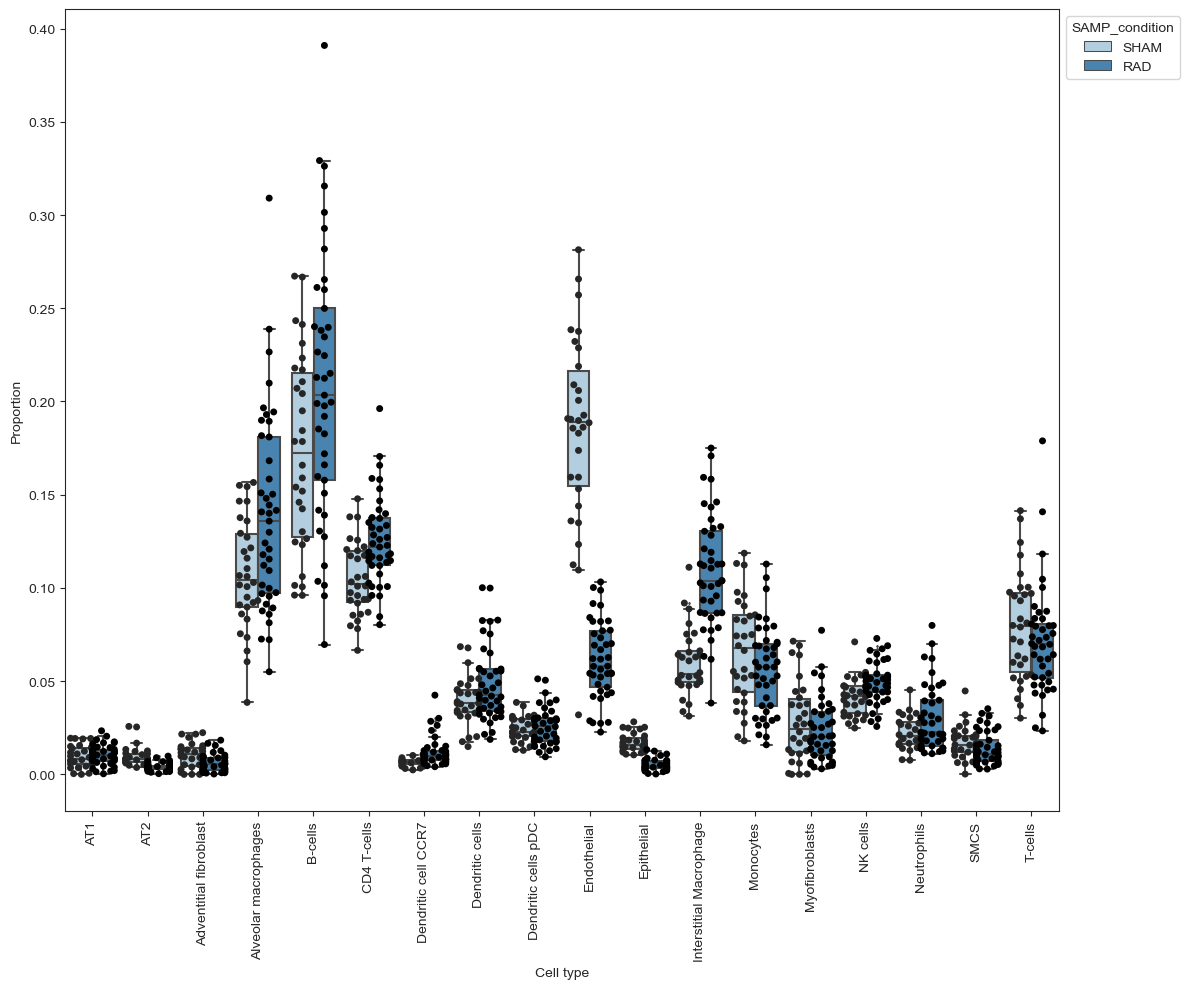

In [14]:
pt.pl.coda.boxplots(sccoda_data, modality_key="RAD_SHAM", feature_name="SAMP_condition", add_dots=True)
plt.show()

In [16]:
sccoda_data = sccoda_model.prepare(sccoda_data, modality_key="RAD_SHAM", formula="SAMP_condition", reference_cell_type="automatic")
sccoda_data["RAD_SHAM"]

Automatic reference selection! Reference cell type set to NK cells

Zero counts encountered in data! Added a pseudocount of 0.5.

AnnData object with n_obs × n_vars = 71 × 18
    obs: 'SAMP_condition', 'SAMP_ID'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'

In [17]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="RAD_SHAM")
sccoda_data["RAD_SHAM"]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|█| 11000/11000 [27:05<00:00,  6.77it/s, 511 steps of size 1.00e-02.


AnnData object with n_obs × n_vars = 71 × 18
    obs: 'SAMP_condition', 'SAMP_ID'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_SAMP_condition[T.SHAM]'

In [18]:
sccoda_model.summary(sccoda_data, modality_key="RAD_SHAM")

                                          Compositional Analysis summary                                           
┌────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────┐
│ Name                                       │ Value                                                              │
├────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Data                                       │ Data: 71 samples, 18 cell types                                    │
│ Reference cell type                        │ NK cells                                                           │
│ Formula                                    │ SAMP_condition                                                     │
└────────────────────────────────────────────┴────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                          Final Parameter  Expected Sample                                                       │
│ Cell Type                                                                                                       │
│ AT1                           0.304           59.673                                                            │
│ AT2                          -0.207           35.797                                                            │
│ Adventitial fibroblast       -0.062           41.383                                                            │
│ Alveolar macrophages          2.671          636.430                                                            │
│ B-cells                       3.075          953.248                                                            │
│ CD4 T-cells                   2.624          607.210                                                            │
│ Dendritic cell CCR7           0.410           66.345                                                            │
│ Dendritic cells               1.678          235.774                                                            │
│ Dendritic cells pDC           1.165          141.157                                                            │
│ Endothelial                   1.923          301.230                                                            │
│ Epithelial                   -0.091           40.200                                                            │
│ Interstitial Macrophage       2.475          523.153                                                            │
│ Monocytes                     1.814          270.122                                                            │
│ Myofibroblasts                0.884          106.578                                                            │
│ NK cells                      1.736          249.854                                                            │
│ Neutrophils                   1.167          141.440                                                            │
│ SMCS                          0.598           80.068                                                            │
│ T-cells                       2.051          342.364                                                            │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                               Final Parameter  Expected Sample  log2-fold change                │
│ Covariate            Cell Type                                                                                  │
│ SAMP_conditionT.SHAM AT1                           0.000           51.441            -0.214                     │
│                      AT2                           0.612           56.906             0.669                     │
│                      Adventitial fibroblast        0.000           35.674            -0.214                     │
│                      Alveolar macrophages          0.000          548.632            -0.214                     │
│                      B-cells                       0.000          821.743            -0.214                     │
│                      CD4 T-cells                   0.000          523.442            -0.214                     │
│                      Dendritic cell CCR7           0.000           57.193            -0.214                     │
│                      Dendritic cells               0.000          203.248            -0.214                     │
│                      Dendritic cells pDC           0.000          121.684            -0.214                     │
│                      Endothelial                   1.182          846.599             1.491                     │
│                      Epithelial                    0.993           93.538             1.218                     │
│                      Interstitial Macrophage      -0.430          293.337            -0.835                     │
│                      Monocytes                     0.270          304.943             0.175                     │
│                      Myofibroblasts                0.000           91.875            -0.214                     │
│                      NK cells                      0.000          215.385            -0.214                     │
│                      Neutrophils                   0.000          121.928            -0.214                     │
│                      SMCS                          0.000           69.022            -0.214                     │
│                      T-cells                       0.241          375.440             0.133                     │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [19]:
sccoda_model.credible_effects(sccoda_data, modality_key="RAD_SHAM")

Covariate               Cell Type              
SAMP_condition[T.SHAM]  AT1                        False
                        AT2                         True
                        Adventitial fibroblast     False
                        Alveolar macrophages       False
                        B-cells                    False
                        CD4 T-cells                False
                        Dendritic cell CCR7        False
                        Dendritic cells            False
                        Dendritic cells pDC        False
                        Endothelial                 True
                        Epithelial                  True
                        Interstitial Macrophage     True
                        Monocytes                   True
                        Myofibroblasts             False
                        NK cells                   False
                        Neutrophils                False
                        SMCS            

In [21]:
#pt.pl.coda.effects_barplot(sccoda_data, modality_key="RAD_SHAM", parameter="Final Parameter")

In [22]:
sccoda_model.set_fdr(sccoda_data, modality_key="RAD_SHAM", est_fdr=0.4)
sccoda_model.summary(sccoda_data, modality_key="RAD_SHAM")

                                          Compositional Analysis summary                                           
┌────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────┐
│ Name                                       │ Value                                                              │
├────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Data                                       │ Data: 71 samples, 18 cell types                                    │
│ Reference cell type                        │ NK cells                                                           │
│ Formula                                    │ SAMP_condition                                                     │
└────────────────────────────────────────────┴────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                          Final Parameter  Expected Sample                                                       │
│ Cell Type                                                                                                       │
│ AT1                           0.304           59.673                                                            │
│ AT2                          -0.207           35.797                                                            │
│ Adventitial fibroblast       -0.062           41.383                                                            │
│ Alveolar macrophages          2.671          636.430                                                            │
│ B-cells                       3.075          953.248                                                            │
│ CD4 T-cells                   2.624          607.210                                                            │
│ Dendritic cell CCR7           0.410           66.345                                                            │
│ Dendritic cells               1.678          235.774                                                            │
│ Dendritic cells pDC           1.165          141.157                                                            │
│ Endothelial                   1.923          301.230                                                            │
│ Epithelial                   -0.091           40.200                                                            │
│ Interstitial Macrophage       2.475          523.153                                                            │
│ Monocytes                     1.814          270.122                                                            │
│ Myofibroblasts                0.884          106.578                                                            │
│ NK cells                      1.736          249.854                                                            │
│ Neutrophils                   1.167          141.440                                                            │
│ SMCS                          0.598           80.068                                                            │
│ T-cells                       2.051          342.364                                                            │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                               Final Parameter  Expected Sample  log2-fold change                │
│ Covariate            Cell Type                                                                                  │
│ SAMP_conditionT.SHAM AT1                          -0.025           50.638            -0.237                     │
│                      AT2                           0.612           57.413             0.682                     │
│                      Adventitial fibroblast        0.287           47.979             0.213                     │
│                      Alveolar macrophages         -0.103          499.417            -0.350                     │
│                      B-cells                       0.000          829.068            -0.201                     │
│                      CD4 T-cells                   0.000          528.109            -0.201                     │
│                      Dendritic cell CCR7          -0.233           45.702            -0.538                     │
│                      Dendritic cells              -0.038          197.371            -0.256                     │
│                      Dendritic cells pDC           0.075          132.271            -0.094                     │
│                      Endothelial                   1.182          854.147             1.504                     │
│                      Epithelial                    0.993           94.372             1.231                     │
│                      Interstitial Macrophage      -0.430          295.952            -0.822                     │
│                      Monocytes                     0.270          307.661             0.188                     │
│                      Myofibroblasts                0.012           93.831            -0.184                     │
│                      NK cells                      0.000          217.305            -0.201                     │
│                      Neutrophils                  -0.060          115.846            -0.288                     │
│                      SMCS                          0.213           86.159             0.106                     │
│                      T-cells                       0.241          378.787             0.146                     │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [37]:
# saving
path = "test"
sccoda_data.write_h5mu("output")

TypeError: Can't implicitly convert non-string objects to strings

Above error raised while writing key '_index' of <class 'h5py._hl.group.Group'> to /

In [40]:
sccoda_data

MuData object with n_obs × n_vars = 343142 × 23764
  3 modalities
    rna:	343071 x 23746
      obs:	'Unnamed: 0', 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ambient_RNA', 'percent_mito', 'percent_ribo', 'S.Score', 'G2M.Score', 'Phase', 'DF_doublet_score', 'DF_call_10pct', 'DF_call_1pct', 'DF_prediction', 'tube_ID', 'SAMP_ID', 'PROJ_bioinf_id', 'PROJ_glpg_id', 'PROJ_area', 'PROJ_species', 'PROJ_tissue', 'PROJ_tissue_detail', 'PROJ_biological_system', 'SAMP_subject_ID', 'SAMP_condition', 'SAMP_treatment', 'SAMP_stage', 'SAMP_exp_group', 'SAMP_sex', 'macrogen_sample_no', 'cell_conc_perml', 'cell_viability_pct', 'aggregates_pct', 'SC_prep', 'library_conc_ng_ul', 'library_size_bp', 'dataset', 'BW_sacrifice_g', 'perc_BW_change_rdm', 'col1_area_pct', 'MitochondrialRatio', 'RibosomalRatio', 'nCount_SCT', 'nFeature_SCT', 'clust_res0.6', 'clust_res0.9', 'clust_res1.2', 'clust_res1.5', 'ident', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden', 'annotation', 'scCODA_sample_id'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'DF_call_10pct_colors', 'Phase_colors', 'SAMP_ID_colors', 'SAMP_condition_colors', 'SAMP_exp_group_colors', 'SAMP_stage_colors', 'SC_prep_colors', 'ident_colors', 'neighbors', 'pca', 'tube_ID_colors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'log1p_norm', 'logcounts'
      obsp:	'connectivities', 'distances'
    coda:	71 x 18
      obs:	'SAMP_condition', 'SAMP_ID'
      var:	'n_cells'
    RAD_SHAM:	71 x 18
      obs:	'SAMP_condition', 'SAMP_ID'
      var:	'n_cells'
      uns:	'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'
      varm:	'intercept_df', 'effect_df_SAMP_condition[T.SHAM]'

In [ ]:
# loading
sccoda_data_2 = mu.read_h5mu(path)

sccoda_model.summary(sccoda_data_2, modality_key="RAD_SHAM")

In [ ]:
test_model = pt.tl.Sccoda()
test_model.get_intercept_df(sccoda_data_2, modality_key="RAD_SHAM")
test_model.get_effect_df(sccoda_data, modality_key="RAD_SHAM")
sccoda_data["RAD_SHAM"].varm["intercept_df"]